In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
C:\Users\keteb\AppData\Local\Temp\ipykernel_23132\682384380.py:66: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


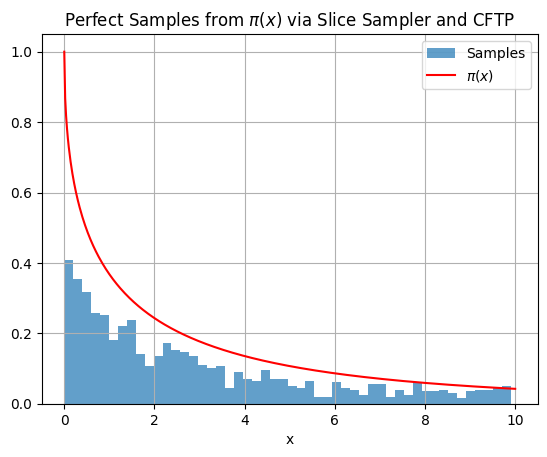

In [23]:

# 1. Densité non normalisée
def unnormalized_pi(x):
    return np.exp(-np.sqrt(x))


def single_step(x, e, W):
    """
    Implements f(x, y) = x' where y = (e, W_1, W_2, ...) as in Section 4.
    """
    u = e * unnormalized_pi(x)
    for wj in W:
        if unnormalized_pi(wj) > u:
            return wj
    raise RuntimeError("Did not find an acceptable W_j. Increase W sample size.")

def generate_W_sequence(W_sample_size):
    w0 = np.random.uniform(0,10)
    W = [w0]

    for _ in range(W_sample_size-1):
        w_new = np.random.uniform(0, W[-1])
        W.append(w_new)
    return W

def CFTP_SS(max_iterations, W_sample_size):
    """
    Implements CFTP with a stochastic recursive sequence (Section 4)
    """
    xmin = 0
    xmax = 10

    T = 1

    e_seq = [np.random.uniform(0, 1) for _ in range(max_iterations)]
    w_seq = [generate_W_sequence(W_sample_size) for _ in range(max_iterations)]
    while T <= max_iterations:
        

        x_lower = xmin
        x_upper = xmax

        for i in reversed(range(T)):
            x_lower = single_step(x_lower, e_seq[i], w_seq[i])
            x_upper = single_step(x_upper, e_seq[i], w_seq[i])

        if np.isclose(x_lower, x_upper, atol=1e-8):
            return x_lower  # Perfect sample from pi(x)
        else:
            T *= 2

    raise RuntimeError("CFTP failed to coalesce within max_iterations")

# Exemple d'utilisation
if __name__ == "__main__":
    max_iterations=2**5
    W_sample_size=1000
    samples = [CFTP_SS(max_iterations, W_sample_size) for _ in tqdm(range(1000))]
    
    import matplotlib.pyplot as plt
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples')
    
    x_vals = np.linspace(0, 10, 500)
    plt.plot(x_vals, unnormalized_pi(x_vals), label=r'$\pi(x)$', color='red')
    plt.legend()
    plt.grid()
    plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
    plt.xlabel("x")
    plt.show()
